In [96]:
import seaborn, torch
import torch.nn.functional as F
from transformers import BertConfig, BertForSequenceClassification, BertModel
import matplotlib.pyplot as plt

In [9]:
config = BertConfig.from_pretrained("/home/qhn/Codes/Projects/KnowledgeDist/Weights/bert_agriculture", num_labels=7)
model = BertForSequenceClassification(config)
model.bert = model.bert.from_pretrained("/home/qhn/Codes/Projects/KnowledgeDist/Weights/bert_agriculture")
model.classifier.load_state_dict(torch.load("/home/qhn/Codes/Projects/KnowledgeDist/Weights/bert_agriculture/classifier.pth"))

<All keys matched successfully>

In [13]:
raw_model = BertModel.from_pretrained("/home/qhn/Codes/Models/Bert-base-chinese")

In [14]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
model_layers_q = [item.attention.self.query for item in model.bert.encoder.layer]
model_layers_k = [item.attention.self.key for item in model.bert.encoder.layer]
model_layers_v = [item.attention.self.value for item in model.bert.encoder.layer]
model_layers = [model_layers_q, model_layers_k, model_layers_v]

In [23]:
raw_model_layers_q = [item.attention.self.query for item in raw_model.encoder.layer]
raw_model_layers_k = [item.attention.self.key for item in raw_model.encoder.layer]
raw_model_layers_v = [item.attention.self.value for item in raw_model.encoder.layer]
raw_model_layers = [raw_model_layers_q, raw_model_layers_k, raw_model_layers_v]

In [35]:
def js_divergence(p, q):
    """
    计算两个概率分布p和q的JS散度。
    p和q应该是形状相同的PyTorch张量。
    """
    # 确保p和q都不是零，以避免对数运算中的数值问题
    p = torch.clamp(p, min=1e-10)
    q = torch.clamp(q, min=1e-10)

    # 计算均值分布m
    m = (p + q) / 2

    # 计算JS散度
    js_div = 0.5 * F.kl_div(torch.log(p), m, reduction='batchmean') + \
             0.5 * F.kl_div(torch.log(q), m, reduction='batchmean')

    return js_div


In [94]:
import numpy as np

scores = []
for model, raw in zip(model_layers, raw_model_layers):
    temp = []
    for p1, p2 in zip(model, raw):
        p1, p2 = p1.weight.view(768, 12, -1).permute(1, 0, 2), p2.weight.view(768, 12, -1).permute(1, 0, 2)
        temp2 = []
        for w1, w2 in zip(p1, p2): 
            js = js_divergence(F.softmax(w1), F.softmax(w2))
            temp2.append(js.detach().numpy())
        temp.append(temp2)
    scores.append(np.array(temp))


/tmp/ipykernel_2844577/397668361.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  js = js_divergence(F.softmax(w1), F.softmax(w2))


[ 0  1  2  3  4  5  6  7  8  9 10 11]


Text(0.5, 23.52222222222222, 'head')

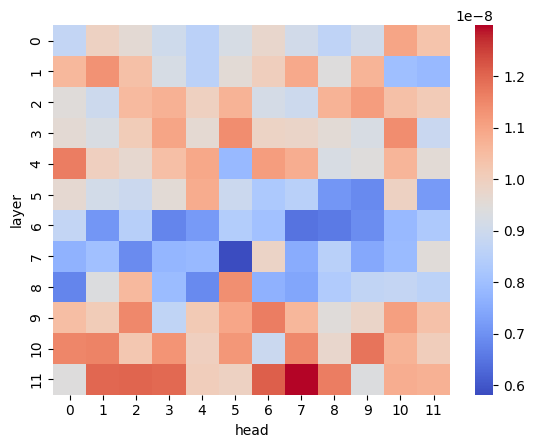

In [130]:

scores = np.array(scores)
seaborn.heatmap(scores[0], cmap="coolwarm")
y = np.arange(scores.shape[1])[::]
print(y)
plt.ylabel('layer')
plt.xlabel('head')


<Axes: >

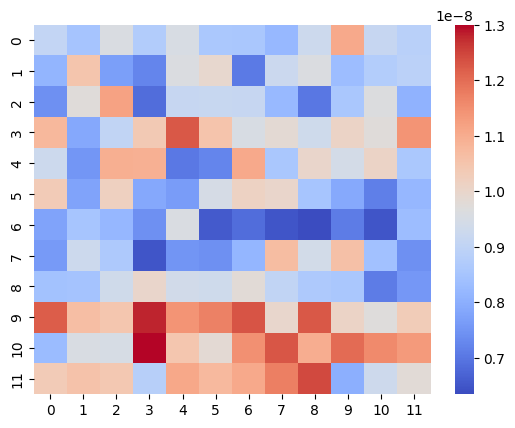

In [127]:
seaborn.heatmap(scores[1], cmap="coolwarm")

<Axes: >

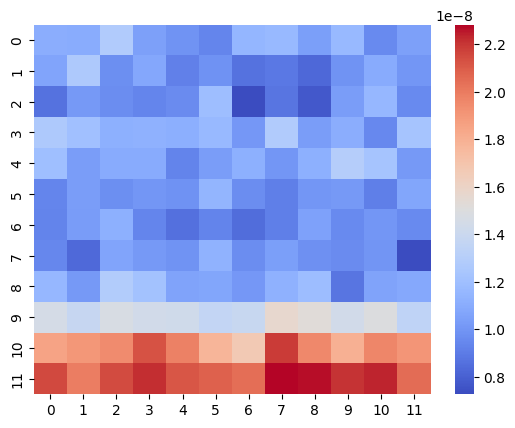

In [128]:
seaborn.heatmap(scores[2], cmap="coolwarm")